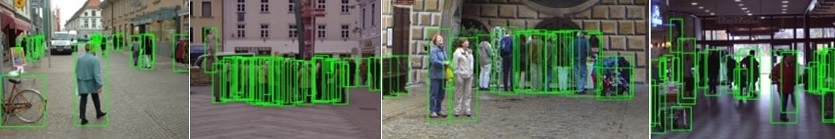

# **Generalisation in Pedestrian Detection: A Comprehensive Benchmarking of CNNs and ViTs Across Diverse Datasets**

This study evaluates six state-of-the-art object detectors—**Faster R-CNN**, **SSD**, **YOLOv1**, **DETR**, **Deformable DETR**, and **RF-DETR**—trained on the **WiderPerson** and **EuroCityPersons** datasets and tested on the **INRIA** dataset to assess their **cross-domain generalisation capabilities**.

This notebook contains the scripts to evaluate these six detectors—**12 models in total**—on a subset of the INRIA dataset consisting of **20 images**. The following metrics will be computed:

- **Precision**
- **Accuracy**
- **Recall**
- **F1 Score**
- **Log Average Miss Rate (LAMR)**
- **Inference Speed**

These results will be referred to in the dissertation report for a comprehensive analysis.


In [3]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **The "COMP3025 [20506329] - Individual Dissertation Single Honours" folder has been submitted on Moodle.**

### Directory Structure

For smooth execution of this script, please ensure your Google Drive is mounted and structured as follows:

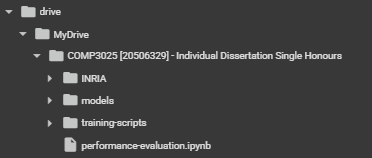

### IMPORTANT: generate a RoboFlow API Key and a HuggingFace Write Token and paste it in the notebook secrets as ROBOFLOW_API_KEY and HF_TOKEN. Allow notebook access to ensure the RF-DETR and YOLOv11 models can be evaluated.

The INRIA dataset may be downloaded through Kaggle or this Google Drive [link](https://drive.google.com/drive/folders/19wZU28cA0qfja40ZCzhyMhRuoaQ4-uuf?usp=sharing) can be used. Simple organise a shortcut to the correct directory.

Install the following modules using pip. This may take a while.

In [4]:
!pip install ultralytics
!pip install rfdetr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [5]:
import os
import time
import random
import json
import cv2
import torch
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from torchvision.models.detection import fasterrcnn_resnet50_fpn, _utils
from torchvision.models.detection.ssd import SSD300_VGG16_Weights, ssd300_vgg16, SSDClassificationHead
from transformers import (
    DetrForObjectDetection,
    DetrImageProcessor,
    DeformableDetrForObjectDetection,
    DeformableDetrImageProcessor
)
from rfdetr import RFDETRBase
from rfdetr.util.coco_classes import COCO_CLASSES
import supervision as sv
import torch.serialization
from ultralytics import YOLO
import json
from torchvision.ops import nms


# defining the device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# setting iou threshold and confidence threshold
IOU_THRESHOLD = 0.5
CONF_THRESHOLD = 0.3
NMS_THRESHOLD = 0.5

# defining directory paths
INRIA_ROOT = '/content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/INRIA/Test'
IMAGE_DIR = os.path.join(INRIA_ROOT, 'JPEGImages')
ANNOTATION_DIR = os.path.join(INRIA_ROOT, 'Annotations')
SAVE_DIR = "/content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/evaluation-output"
SAVE_INRIA_DIR = "/content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/evaluation-output/inria-ground-truths"
# creating folder to save the images with predicted annotations
os.makedirs(SAVE_DIR,exist_ok=True)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [6]:
# parse annotation xml file from Annotations/
def parse_voc_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    boxes = []
    for obj in root.findall('object'):
        label = obj.find('name').text
        if label.lower() != 'person':
            continue
        bbox = obj.find('bndbox')
        box = {
            'xmin': int(bbox.find('xmin').text),
            'ymin': int(bbox.find('ymin').text),
            'xmax': int(bbox.find('xmax').text),
            'ymax': int(bbox.find('ymax').text),
            'label': 'pedestrian'
        }
        boxes.append(box)
    return boxes

# load the subset of 20 images
def load_inria_subset(num_images):
    annotations = sorted(os.listdir(ANNOTATION_DIR))
    selected = []
    selected_ids = []

    for xml_name in annotations:
        image_id = os.path.splitext(xml_name)[0]
        xml_path = os.path.join(ANNOTATION_DIR, xml_name)
        img_path = os.path.join(IMAGE_DIR, image_id + '.png')

        if not os.path.exists(img_path):
            continue

        boxes = parse_voc_annotation(xml_path)
        if boxes:
            selected.append({
                'image_id': image_id,
                'image_path': img_path,
                'boxes': boxes
            })
            selected_ids.append(image_id)

    # sort by number of boxes to ensure mix of sparse and dense
    selected.sort(key=lambda x: len(x['boxes']))
    half_sparse = selected[:num_images // 2]
    half_dense = selected[-(num_images // 2):]
    diverse_subset = half_sparse + half_dense
    random.shuffle(diverse_subset)

    final_ids = [entry['image_id'] for entry in diverse_subset]
    return diverse_subset, final_ids


# visualise and save ground truth samples
def visualise_sample(image_info, save_dir):
    img = Image.open(image_info['image_path'])
    fig, ax = plt.subplots()
    ax.imshow(img)
    # Draw bounding boxes
    for box in image_info['boxes']:
        rect = patches.Rectangle(
            (box['xmin'], box['ymin']),
            box['xmax'] - box['xmin'],
            box['ymax'] - box['ymin'],
            linewidth=2,
            edgecolor='r',
            facecolor='none'
        )
        ax.add_patch(rect)
    ax.axis('off')
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, f"{image_info['image_id']}.jpg")
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close(fig)

In [7]:
# parse all the annotations and return ground truth boxes
def parse_inria_annotations(annotation_dir, image_dir, filter_ids=None):
    gt_boxes_dict = {}
    for xml_file in os.listdir(annotation_dir):
        if not xml_file.endswith(".xml"):
            continue

        image_id = os.path.splitext(xml_file)[0]
        if filter_ids and image_id not in filter_ids:
            continue

        tree = ET.parse(os.path.join(annotation_dir, xml_file))
        root = tree.getroot()
        filename = root.find("filename").text

        boxes = []
        for obj in root.findall("object"):
            label = obj.find("name").text.lower()
            if label != "person":
                continue

            bbox = obj.find("bndbox")
            xmin = int(float(bbox.find("xmin").text))
            ymin = int(float(bbox.find("ymin").text))
            xmax = int(float(bbox.find("xmax").text))
            ymax = int(float(bbox.find("ymax").text))
            boxes.append([xmin, ymin, xmax, ymax])

        if boxes:
            gt_boxes_dict[filename] = boxes

    print(f"Parsed {len(gt_boxes_dict)} filtered images with valid 'person' annotations.")
    return gt_boxes_dict

In [8]:
# IoU functions for differently formatted bounding boxes (different models return different formats)
def compute_iou(boxA, boxB):
    xA = max(boxA[0] if isinstance(boxA, list) else boxA['xmin'],
             boxB[0] if isinstance(boxB, list) else boxB['xmin'])
    yA = max(boxA[1] if isinstance(boxA, list) else boxA['ymin'],
             boxB[1] if isinstance(boxB, list) else boxB['ymin'])
    xB = min(boxA[2] if isinstance(boxA, list) else boxA['xmax'],
             boxB[2] if isinstance(boxB, list) else boxB['xmax'])
    yB = min(boxA[3] if isinstance(boxA, list) else boxA['ymax'],
             boxB[3] if isinstance(boxB, list) else boxB['ymax'])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = max(0, boxA[2] - boxA[0]) * max(0, boxA[3] - boxA[1])
    boxBArea = max(0, boxB[2] - boxB[0]) * max(0, boxB[3] - boxB[1])
    return interArea / float(boxAArea + boxBArea - interArea + 1e-6)

def compute_rfdetr_iou(boxA, boxB):
    def extract_coords(box):
        if isinstance(box, dict):
            return box['xmin'], box['ymin'], box['xmax'], box['ymax']
        elif isinstance(box, (list, tuple, np.ndarray)):
            return box[0], box[1], box[2], box[3]
        else:
            raise TypeError(f"Unsupported box type: {type(box)}")

    xA1, yA1, xA2, yA2 = extract_coords(boxA)
    xB1, yB1, xB2, yB2 = extract_coords(boxB)

    x_left = max(xA1, xB1)
    y_top = max(yA1, yB1)
    x_right = min(xA2, xB2)
    y_bottom = min(yA2, yB2)

    if x_right < x_left or y_bottom < y_top:
        return 0.0
    inter_area = (x_right - x_left) * (y_bottom - y_top)
    boxA_area = (xA2 - xA1) * (yA2 - yA1)
    boxB_area = (xB2 - xB1) * (yB2 - yB1)

    iou = inter_area / float(boxA_area + boxB_area - inter_area)
    return iou

def compute_iou_detr(boxA, boxB):
    def to_xyxy(box):
        if isinstance(box, dict):
            return [box["xmin"], box["ymin"], box["xmax"], box["ymax"]]
        elif isinstance(box, (list, tuple, np.ndarray)):
            return list(box)
        else:
            raise TypeError(f"Unsupported box type: {type(box)}")

    boxA = to_xyxy(boxA)
    boxB = to_xyxy(boxB)

    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = max(0, boxA[2] - boxA[0]) * max(0, boxA[3] - boxA[1])
    boxBArea = max(0, boxB[2] - boxB[0]) * max(0, boxB[3] - boxB[1])

    iou = interArea / float(boxAArea + boxBArea - interArea + 1e-6)
    return iou


In [9]:
# get subset of 20 images, read annotations, save annotated ground truth images
subset, selected_ids = load_inria_subset(20)
for image_info in subset:
    visualise_sample(image_info, save_dir=SAVE_INRIA_DIR)
gt_boxes_dict = parse_inria_annotations(ANNOTATION_DIR, IMAGE_DIR, filter_ids=selected_ids)
image_paths = [os.path.join(IMAGE_DIR, img_id + ".png") for img_id in selected_ids]


Parsed 20 filtered images with valid 'person' annotations.


In [11]:
# this function evaluates the finetuned faster rcnn models on the 20 images
def evaluate_fasterrcnn_model(model_name, model_path, inria_subset, numclasses):
    print(f"\nEvaluating {model_name}...")
    model = fasterrcnn_resnet50_fpn(pretrained=False, num_classes=numclasses).to(DEVICE)
    # Load weights
    checkpoint = torch.load(model_path, map_location=DEVICE)
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)

    model.eval()

    output_dir = f"{SAVE_DIR}/{model_name}"
    os.makedirs(output_dir, exist_ok=True)

    true_positives = 0
    false_positives = 0
    false_negatives = 0
    all_ious = []
    start_time = time.time()

    for sample in tqdm(inria_subset):
        img_path = sample['image_path']
        gt_boxes = sample['boxes']
        img = cv2.imread(img_path)
        img_tensor = torch.from_numpy(img / 255.).permute(2, 0, 1).float().unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            preds = model(img_tensor)[0]

        pred_boxes = preds['boxes'][preds['scores'] > CONF_THRESHOLD].cpu().numpy()

        matched_gt = set()
        for pb in pred_boxes:
            pb = [int(c) for c in pb]
            matched = False
            for idx, gt in enumerate(gt_boxes):
                gt_box = [gt['xmin'], gt['ymin'], gt['xmax'], gt['ymax']]
                iou = compute_iou(pb, gt_box)
                if iou >= IOU_THRESHOLD and idx not in matched_gt:
                    true_positives += 1
                    matched_gt.add(idx)
                    all_ious.append(iou)
                    matched = True
                    break
            if not matched:
                false_positives += 1
        false_negatives += len(gt_boxes) - len(matched_gt)

        # Draw predicted boxes
        for box in pred_boxes:
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        filename = os.path.basename(sample['image_path']).split('.')[0]
        cv2.imwrite(os.path.join(output_dir, f"{filename}.jpg"), img)


    elapsed = time.time() - start_time
    precision = true_positives / (true_positives + false_positives + 1e-6)
    recall = true_positives / (true_positives + false_negatives + 1e-6)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
    accuracy = true_positives / (true_positives + false_negatives + false_positives + 1e-6)
    mean_iou = np.mean(all_ious) if all_ious else 0.0
    lamr = np.exp(np.mean(np.log(np.clip(1 - recall, 1e-10, 1))))

    print(f"\nResults for {model_name}:")
    print(f" Precision: {precision:.4f}")
    print(f" Recall: {recall:.4f}")
    print(f" F1 Score: {f1:.4f}")
    print(f" Accuracy: {accuracy:.4f}")
    print(f" Mean IoU: {mean_iou:.4f}")
    print(f" Inference Time: {elapsed:.2f}s")
    print(f" LAMR: {lamr:.4f}\n")

    return {
        'model': model_name,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': accuracy,
        'mean_iou': mean_iou,
        'time': elapsed,
        'lamr': lamr
    }


In [12]:
# evaluating fine-tuned fasterrrcnn models
evaluate_fasterrcnn_model('fasterrcnn-widerperson', '/content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/models/fasterrcnn-widerperson.pth', subset, 4)
evaluate_fasterrcnn_model('fasterrcnn-ecp', '/content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/models/fasterrcnn-ecp.pth', subset, 12)


Evaluating fasterrcnn-widerperson...


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 98.3MB/s]
100%|██████████| 20/20 [03:09<00:00,  9.47s/it]



Results for fasterrcnn-widerperson:
 Precision: 0.5669
 Recall: 0.9175
 F1 Score: 0.7008
 Accuracy: 0.5394
 Mean IoU: 0.7578
 Inference Time: 189.43s
 LAMR: 0.0825


Evaluating fasterrcnn-ecp...


100%|██████████| 20/20 [02:58<00:00,  8.93s/it]


Results for fasterrcnn-ecp:
 Precision: 0.3309
 Recall: 0.9175
 F1 Score: 0.4863
 Accuracy: 0.3213
 Mean IoU: 0.7805
 Inference Time: 178.55s
 LAMR: 0.0825



{'model': 'fasterrcnn-ecp',
 'precision': 0.3308550173574163,
 'recall': 0.9175257637368478,
 'f1': 0.48633840558124797,
 'accuracy': 0.3212996378292432,
 'mean_iou': np.float64(0.780463391534871),
 'time': 178.55318665504456,
 'lamr': np.float64(0.08247423626315219)}

In [13]:
def evaluate_rfdetr(model_path, image_paths, gt_boxes_dict, output_dir):
    print(f"\nEvaluating RF-DETR from {model_path}...")
    model = RFDETRBase(pretrain_weights=model_path)

    true_positives, false_positives, false_negatives = 0, 0, 0
    all_ious = []
    os.makedirs(output_dir, exist_ok=True)
    start_time = time.time()

    for img_path in tqdm(image_paths):
        image = Image.open(img_path).convert("RGB")
        detections = model.predict(image, threshold=0.5)
        pred_boxes = detections.xyxy

        gt_boxes = gt_boxes_dict[os.path.basename(img_path)]
        matched_gt = set()

        for pb in pred_boxes:
            matched = False
            for idx, gt in enumerate(gt_boxes):
                iou = compute_rfdetr_iou(pb, gt)
                if iou >= IOU_THRESHOLD and idx not in matched_gt:
                    true_positives += 1
                    all_ious.append(iou)
                    matched_gt.add(idx)
                    matched = True
                    break
            if not matched:
                false_positives += 1

        false_negatives += len(gt_boxes) - len(matched_gt)

        annotated = sv.BoxAnnotator().annotate(image.copy(), detections)
        sv.LabelAnnotator().annotate(annotated, detections)
        annotated.save(os.path.join(output_dir, f"rfdetr_{os.path.basename(img_path)}"))

    elapsed = time.time() - start_time
    precision = true_positives / (true_positives + false_positives + 1e-6)
    recall = true_positives / (true_positives + false_negatives + 1e-6)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
    accuracy = true_positives / (true_positives + false_positives + false_negatives + 1e-6)
    mean_iou = np.mean(all_ious) if all_ious else 0.0
    lamr = np.exp(np.mean(np.log(np.clip(1 - recall, 1e-10, 1))))

    print(f"\nRF-DETR Results:")
    print(f" Precision: {precision:.4f}")
    print(f" Recall: {recall:.4f}")
    print(f" F1 Score: {f1:.4f}")
    print(f" Accuracy: {accuracy:.4f}")
    print(f" Mean IoU: {mean_iou:.4f}")
    print(f" Inference Time: {elapsed:.2f}s")
    print(f" LAMR: {lamr:.4f}")

    return {
        'model': "RFDETR",
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': accuracy,
        'mean_iou': mean_iou,
        'time': elapsed,
        'lamr': lamr
    }


In [14]:
# evaluating fine-tuned rf-detr models
evaluate_rfdetr('/content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/models/rfdetr-widerperson.pth', image_paths, gt_boxes_dict, output_dir=f"{SAVE_DIR}/rfdetr-widerperson")
evaluate_rfdetr('/content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/models/rfdetr-ecp.pth', image_paths, gt_boxes_dict, output_dir=f"{SAVE_DIR}/rfdetr-ecp")


Evaluating RF-DETR from /content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/models/rfdetr-widerperson.pth...


config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

Loading pretrain weights


reinitializing detection head with 11 classes
100%|██████████| 20/20 [00:59<00:00,  2.96s/it]



RF-DETR Results:
 Precision: 0.6567
 Recall: 0.9072
 F1 Score: 0.7619
 Accuracy: 0.6154
 Mean IoU: 0.8069
 Inference Time: 59.15s
 LAMR: 0.0928

Evaluating RF-DETR from /content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/models/rfdetr-ecp.pth...
Loading pretrain weights


reinitializing detection head with 11 classes
100%|██████████| 20/20 [00:54<00:00,  2.70s/it]


RF-DETR Results:
 Precision: 0.6618
 Recall: 0.9278
 F1 Score: 0.7725
 Accuracy: 0.6294
 Mean IoU: 0.8082
 Inference Time: 54.06s
 LAMR: 0.0722


{'model': 'RFDETR',
 'precision': 0.661764701016436,
 'recall': 0.927835041981082,
 'f1': 0.7725316962186924,
 'accuracy': 0.6293706249694362,
 'mean_iou': np.float64(0.8081936418738093),
 'time': 54.0612587928772,
 'lamr': np.float64(0.07216495801891798)}

In [15]:
def evaluate_yolo11(model_path, image_paths, gt_boxes_dict, output_dir):
    print(f"\nEvaluating YOLO11 from {model_path}...")
    model = YOLO(model_path)
    true_positives, false_positives, false_negatives = 0, 0, 0
    all_ious = []
    os.makedirs(output_dir, exist_ok=True)
    start_time = time.time()

    for img_path in tqdm(image_paths):
        results = model(img_path)[0]  # Only one image
        pred_boxes = results.boxes.xyxy.cpu().numpy()

        # Ground truth
        gt_boxes = gt_boxes_dict[os.path.basename(img_path)]
        matched_gt = set()

        for pb in pred_boxes:
            matched = False
            for idx, gt in enumerate(gt_boxes):
                iou = compute_rfdetr_iou(pb, gt)
                if iou >= IOU_THRESHOLD and idx not in matched_gt:
                    true_positives += 1
                    all_ious.append(iou)
                    matched_gt.add(idx)
                    matched = True
                    break
            if not matched:
                false_positives += 1

        false_negatives += len(gt_boxes) - len(matched_gt)

        # Save annotated image
        annotated_frame = results.plot()  # This returns a numpy image with boxes drawn
        filename = os.path.basename(img_path)
        output_path = os.path.join(output_dir, filename)
        cv2.imwrite(output_path, annotated_frame)

    elapsed = time.time() - start_time
    precision = true_positives / (true_positives + false_positives + 1e-6)
    recall = true_positives / (true_positives + false_negatives + 1e-6)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
    accuracy = true_positives / (true_positives + false_positives + false_negatives + 1e-6)
    mean_iou = np.mean(all_ious) if all_ious else 0.0
    lamr = np.exp(np.mean(np.log(np.clip(1 - recall, 1e-10, 1))))

    print(f"\nYOLO11 Results:")
    print(f" Precision: {precision:.4f}")
    print(f" Recall: {recall:.4f}")
    print(f" F1 Score: {f1:.4f}")
    print(f" Accuracy: {accuracy:.4f}")
    print(f" Mean IoU: {mean_iou:.4f}")
    print(f" Inference Time: {elapsed:.2f}s")
    print(f" LAMR: {lamr:.4f}")

    return {
        'model': "YOLO11",
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': accuracy,
        'mean_iou': mean_iou,
        'time': elapsed,
        'lamr': lamr
    }


In [16]:
# YOLOv11
evaluate_yolo11('/content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/models/yolo11-widerperson/detect/train/weights/best.pt', image_paths, gt_boxes_dict, output_dir=f"{SAVE_DIR}/yolo11-widerperson")
evaluate_yolo11('/content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/models/yolo11-ecp/detect/train/weights/best.pt', image_paths, gt_boxes_dict, output_dir=f"{SAVE_DIR}/yolo11-ecp")




Evaluating YOLO11 from /content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/models/yolo11-widerperson/detect/train/weights/best.pt...


  0%|          | 0/20 [00:00<?, ?it/s]


image 1/1 /content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/INRIA/Test/JPEGImages/crop001634.png: 448x640 1 pedestrian, 183.2ms
Speed: 17.5ms preprocess, 183.2ms inference, 3.8ms postprocess per image at shape (1, 3, 448, 640)


  5%|▌         | 1/20 [00:01<00:33,  1.77s/it]


image 1/1 /content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/INRIA/Test/JPEGImages/crop001654.png: 544x640 1 pedestrian, 192.7ms
Speed: 4.2ms preprocess, 192.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)


 10%|█         | 2/20 [00:02<00:16,  1.07it/s]


image 1/1 /content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/INRIA/Test/JPEGImages/crop001545.png: 480x640 1 pedestrian, 188.5ms
Speed: 3.8ms preprocess, 188.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


 15%|█▌        | 3/20 [00:02<00:11,  1.49it/s]


image 1/1 /content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/INRIA/Test/JPEGImages/person_207.png: 480x640 5 pedestrians, 166.9ms
Speed: 2.4ms preprocess, 166.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


 20%|██        | 4/20 [00:02<00:07,  2.01it/s]


image 1/1 /content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/INRIA/Test/JPEGImages/crop001549.png: 480x640 1 pedestrian, 160.9ms
Speed: 3.6ms preprocess, 160.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


 25%|██▌       | 5/20 [00:03<00:06,  2.33it/s]


image 1/1 /content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/INRIA/Test/JPEGImages/person_236.png: 480x640 11 pedestrians, 153.3ms
Speed: 2.9ms preprocess, 153.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


 30%|███       | 6/20 [00:03<00:05,  2.76it/s]


image 1/1 /content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/INRIA/Test/JPEGImages/person_200.png: 480x640 17 pedestrians, 173.2ms
Speed: 2.3ms preprocess, 173.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


 35%|███▌      | 7/20 [00:03<00:04,  3.07it/s]


image 1/1 /content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/INRIA/Test/JPEGImages/crop001653.png: 448x640 1 pedestrian, 154.2ms
Speed: 3.4ms preprocess, 154.2ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


 40%|████      | 8/20 [00:03<00:03,  3.21it/s]


image 1/1 /content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/INRIA/Test/JPEGImages/crop001574.png: 640x512 1 pedestrian, 192.0ms
Speed: 3.3ms preprocess, 192.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 512)


 45%|████▌     | 9/20 [00:04<00:03,  3.35it/s]


image 1/1 /content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/INRIA/Test/JPEGImages/crop001590.png: 480x640 1 pedestrian, 160.9ms
Speed: 3.4ms preprocess, 160.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


 50%|█████     | 10/20 [00:04<00:03,  3.16it/s]


image 1/1 /content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/INRIA/Test/JPEGImages/person_303.png: 480x640 6 pedestrians, 154.0ms
Speed: 2.4ms preprocess, 154.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


 55%|█████▌    | 11/20 [00:04<00:02,  3.46it/s]


image 1/1 /content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/INRIA/Test/JPEGImages/person_132.png: 480x640 11 pedestrians, 159.7ms
Speed: 2.4ms preprocess, 159.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


 60%|██████    | 12/20 [00:04<00:02,  3.57it/s]


image 1/1 /content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/INRIA/Test/JPEGImages/crop001719.png: 448x640 8 pedestrians, 147.6ms
Speed: 3.5ms preprocess, 147.6ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 65%|██████▌   | 13/20 [00:05<00:02,  3.37it/s]


image 1/1 /content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/INRIA/Test/JPEGImages/crop001676.png: 544x640 7 pedestrians, 192.7ms
Speed: 4.1ms preprocess, 192.7ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)


 70%|███████   | 14/20 [00:05<00:01,  3.20it/s]


image 1/1 /content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/INRIA/Test/JPEGImages/crop001604.png: 544x640 1 pedestrian, 184.0ms
Speed: 3.7ms preprocess, 184.0ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)


 75%|███████▌  | 15/20 [00:05<00:01,  3.33it/s]


image 1/1 /content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/INRIA/Test/JPEGImages/crop001511.png: 640x512 1 pedestrian, 168.5ms
Speed: 3.8ms preprocess, 168.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 512)


 80%|████████  | 16/20 [00:06<00:01,  3.32it/s]


image 1/1 /content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/INRIA/Test/JPEGImages/person_and_bike_028.png: 480x640 6 pedestrians, 154.3ms
Speed: 2.5ms preprocess, 154.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


 85%|████████▌ | 17/20 [00:06<00:00,  3.56it/s]


image 1/1 /content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/INRIA/Test/JPEGImages/crop001602.png: 640x512 1 pedestrian, 170.8ms
Speed: 5.4ms preprocess, 170.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 512)


 90%|█████████ | 18/20 [00:06<00:00,  3.46it/s]


image 1/1 /content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/INRIA/Test/JPEGImages/person_204.png: 480x640 9 pedestrians, 162.7ms
Speed: 2.3ms preprocess, 162.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


 95%|█████████▌| 19/20 [00:06<00:00,  3.67it/s]


image 1/1 /content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/INRIA/Test/JPEGImages/crop001607.png: 352x640 9 pedestrians, 133.2ms
Speed: 2.7ms preprocess, 133.2ms inference, 1.1ms postprocess per image at shape (1, 3, 352, 640)


100%|██████████| 20/20 [00:07<00:00,  2.78it/s]


YOLO11 Results:
 Precision: 0.8283
 Recall: 0.8454
 F1 Score: 0.8367
 Accuracy: 0.7193
 Mean IoU: 0.7674
 Inference Time: 7.20s
 LAMR: 0.1546

Evaluating YOLO11 from /content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/models/yolo11-ecp/detect/train/weights/best.pt...



  0%|          | 0/20 [00:00<?, ?it/s]


image 1/1 /content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/INRIA/Test/JPEGImages/crop001634.png: 448x640 1 person-group-far-away, 224.3ms
Speed: 4.7ms preprocess, 224.3ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


  5%|▌         | 1/20 [00:00<00:09,  1.97it/s]


image 1/1 /content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/INRIA/Test/JPEGImages/crop001654.png: 544x640 1 person-group-far-away, 292.9ms
Speed: 5.8ms preprocess, 292.9ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)


 10%|█         | 2/20 [00:01<00:08,  2.00it/s]


image 1/1 /content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/INRIA/Test/JPEGImages/crop001545.png: 480x640 1 person-group-far-away, 247.5ms
Speed: 5.5ms preprocess, 247.5ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


 15%|█▌        | 3/20 [00:01<00:08,  1.98it/s]


image 1/1 /content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/INRIA/Test/JPEGImages/person_207.png: 480x640 7 person-group-far-aways, 1 bicycle-group, 209.1ms
Speed: 3.0ms preprocess, 209.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


 20%|██        | 4/20 [00:01<00:06,  2.38it/s]


image 1/1 /content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/INRIA/Test/JPEGImages/crop001549.png: 480x640 1 person-group-far-away, 163.8ms
Speed: 3.7ms preprocess, 163.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


 25%|██▌       | 5/20 [00:02<00:05,  2.62it/s]


image 1/1 /content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/INRIA/Test/JPEGImages/person_236.png: 480x640 11 person-group-far-aways, 198.0ms
Speed: 2.4ms preprocess, 198.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


 30%|███       | 6/20 [00:02<00:04,  2.89it/s]


image 1/1 /content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/INRIA/Test/JPEGImages/person_200.png: 480x640 23 person-group-far-aways, 166.1ms
Speed: 2.5ms preprocess, 166.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 35%|███▌      | 7/20 [00:02<00:04,  3.20it/s]


image 1/1 /content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/INRIA/Test/JPEGImages/crop001653.png: 448x640 1 person-group-far-away, 166.3ms
Speed: 3.3ms preprocess, 166.3ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


 40%|████      | 8/20 [00:02<00:03,  3.26it/s]


image 1/1 /content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/INRIA/Test/JPEGImages/crop001574.png: 640x512 (no detections), 169.9ms
Speed: 3.6ms preprocess, 169.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


 45%|████▌     | 9/20 [00:03<00:03,  3.50it/s]


image 1/1 /content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/INRIA/Test/JPEGImages/crop001590.png: 480x640 (no detections), 155.0ms
Speed: 3.3ms preprocess, 155.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


 50%|█████     | 10/20 [00:03<00:03,  3.30it/s]


image 1/1 /content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/INRIA/Test/JPEGImages/person_303.png: 480x640 6 person-group-far-aways, 162.1ms
Speed: 2.4ms preprocess, 162.1ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


 55%|█████▌    | 11/20 [00:03<00:02,  3.51it/s]


image 1/1 /content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/INRIA/Test/JPEGImages/person_132.png: 480x640 11 person-group-far-aways, 174.4ms
Speed: 2.4ms preprocess, 174.4ms inference, 3.7ms postprocess per image at shape (1, 3, 480, 640)


 60%|██████    | 12/20 [00:04<00:02,  3.60it/s]


image 1/1 /content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/INRIA/Test/JPEGImages/crop001719.png: 448x640 13 person-group-far-aways, 148.2ms
Speed: 3.5ms preprocess, 148.2ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


 65%|██████▌   | 13/20 [00:04<00:02,  3.40it/s]


image 1/1 /content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/INRIA/Test/JPEGImages/crop001676.png: 544x640 7 person-group-far-aways, 182.1ms
Speed: 4.6ms preprocess, 182.1ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)


 70%|███████   | 14/20 [00:04<00:01,  3.25it/s]


image 1/1 /content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/INRIA/Test/JPEGImages/crop001604.png: 544x640 3 person-group-far-aways, 196.6ms
Speed: 3.8ms preprocess, 196.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)


 75%|███████▌  | 15/20 [00:05<00:01,  2.96it/s]


image 1/1 /content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/INRIA/Test/JPEGImages/crop001511.png: 640x512 1 person-group-far-away, 171.9ms
Speed: 3.8ms preprocess, 171.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 512)


 80%|████████  | 16/20 [00:05<00:01,  3.06it/s]


image 1/1 /content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/INRIA/Test/JPEGImages/person_and_bike_028.png: 480x640 9 person-group-far-aways, 1 pedestrian, 157.5ms
Speed: 2.3ms preprocess, 157.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


 85%|████████▌ | 17/20 [00:05<00:00,  3.34it/s]


image 1/1 /content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/INRIA/Test/JPEGImages/crop001602.png: 640x512 1 person-group-far-away, 186.4ms
Speed: 3.8ms preprocess, 186.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 512)


 90%|█████████ | 18/20 [00:05<00:00,  3.27it/s]


image 1/1 /content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/INRIA/Test/JPEGImages/person_204.png: 480x640 10 person-group-far-aways, 161.0ms
Speed: 2.4ms preprocess, 161.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


 95%|█████████▌| 19/20 [00:06<00:00,  3.51it/s]


image 1/1 /content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/INRIA/Test/JPEGImages/crop001607.png: 352x640 9 person-group-far-aways, 1 rider, 119.9ms
Speed: 2.7ms preprocess, 119.9ms inference, 1.1ms postprocess per image at shape (1, 3, 352, 640)


100%|██████████| 20/20 [00:06<00:00,  3.10it/s]


YOLO11 Results:
 Precision: 0.6807
 Recall: 0.8351
 F1 Score: 0.7500
 Accuracy: 0.6000
 Mean IoU: 0.7855
 Inference Time: 6.45s
 LAMR: 0.1649


{'model': 'YOLO11',
 'precision': 0.6806722631876281,
 'recall': 0.8350515377829738,
 'f1': 0.7499994982427819,
 'accuracy': 0.5999999955555556,
 'mean_iou': np.float64(0.7855371782729319),
 'time': 6.4451398849487305,
 'lamr': np.float64(0.1649484622170262)}

In [17]:
# function to evaluate detr and deformable detr models
def evaluate_transformer_model(model, processor, model_name, image_paths, gt_boxes_dict, output_dir):
    print(f"\nEvaluating {model_name}...")
    model.to(DEVICE)
    model.eval()

    true_positives = 0
    false_positives = 0
    false_negatives = 0
    all_ious = []
    os.makedirs(output_dir, exist_ok=True)
    start_time = time.time()

    for img_path in tqdm(image_paths):
        image = Image.open(img_path).convert("RGB")
        inputs = processor(images=image, return_tensors="pt").to(DEVICE)

        with torch.no_grad():
            outputs = model(**inputs)

        target_sizes = torch.tensor([image.size[::-1]])
        results = processor.post_process_object_detection(outputs, threshold=CONF_THRESHOLD, target_sizes=target_sizes)[0]
        pred_boxes = results['boxes'].cpu().numpy()

        gt_boxes = gt_boxes_dict[os.path.basename(img_path)]
        matched_gt = set()

        for pb in pred_boxes:
            matched = False
            for idx, gt in enumerate(gt_boxes):
                iou = compute_iou_detr(pb, gt)
                if iou >= IOU_THRESHOLD and idx not in matched_gt:
                    true_positives += 1
                    all_ious.append(iou)
                    matched_gt.add(idx)
                    matched = True
                    break
            if not matched:
                false_positives += 1

        false_negatives += len(gt_boxes) - len(matched_gt)

        img_np = np.array(image)
        for box in pred_boxes:
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(img_np, (x1, y1), (x2, y2), (0, 255, 0), 2)
        out_path = os.path.join(output_dir, f"{model_name}_{os.path.basename(img_path)}")
        cv2.imwrite(out_path, cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR))

    elapsed = time.time() - start_time
    precision = true_positives / (true_positives + false_positives + 1e-6)
    recall = true_positives / (true_positives + false_negatives + 1e-6)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
    accuracy = true_positives / (true_positives + false_positives + false_negatives + 1e-6)
    mean_iou = np.mean(all_ious) if all_ious else 0.0
    lamr = np.exp(np.mean(np.log(np.clip(1 - recall, 1e-10, 1))))

    print(f"\n{model_name} Results:")
    print(f" Precision: {precision:.4f}")
    print(f" Recall: {recall:.4f}")
    print(f" F1 Score: {f1:.4f}")
    print(f" Accuracy: {accuracy:.4f}")
    print(f" Mean IoU: {mean_iou:.4f}")
    print(f" Inference Time: {elapsed:.2f}s")
    print(f" LAMR: {lamr:.4f}")

    return {
        'model': model_name,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': accuracy,
        'mean_iou': mean_iou,
        'time': elapsed,
        'lamr': lamr
    }


In [18]:
# evaluating detr models
detr_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

config_path = "/content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/models/detr-widerperson/checkpoint-10055/config.json"
with open(config_path, "r") as f:
    config = json.load(f)

config["use_pretrained_backbone"] = False

with open(config_path, "w") as f:
    json.dump(config, f, indent=2)

detr_wp_model = DetrForObjectDetection.from_pretrained("/content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/models/detr-widerperson/checkpoint-10055")
evaluate_transformer_model(detr_wp_model, detr_processor, "DETR-WiderPerson", image_paths, gt_boxes_dict, output_dir=f"{SAVE_DIR}/detr-wp")

config_path = "/content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/models/detr-ecp/checkpoint-7900/config.json"
with open(config_path, "r") as f:
    config = json.load(f)

config["use_pretrained_backbone"] = False

with open(config_path, "w") as f:
    json.dump(config, f, indent=2)

detr_ecp_model = DetrForObjectDetection.from_pretrained("/content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/models/detr-ecp/checkpoint-7900")
evaluate_transformer_model(detr_ecp_model, detr_processor, "DETR-ECP", image_paths, gt_boxes_dict, output_dir=f"{SAVE_DIR}/detr-ecp")


preprocessor_config.json:   0%|          | 0.00/290 [00:00<?, ?B/s]


Evaluating DETR-WiderPerson...


100%|██████████| 20/20 [01:45<00:00,  5.27s/it]



DETR-WiderPerson Results:
 Precision: 0.2174
 Recall: 0.9278
 F1 Score: 0.3523
 Accuracy: 0.2138
 Mean IoU: 0.7653
 Inference Time: 105.35s
 LAMR: 0.0722

Evaluating DETR-ECP...


100%|██████████| 20/20 [01:37<00:00,  4.89s/it]


DETR-ECP Results:
 Precision: 0.1924
 Recall: 0.9381
 F1 Score: 0.3193
 Accuracy: 0.1900
 Mean IoU: 0.7261
 Inference Time: 97.75s
 LAMR: 0.0619


{'model': 'DETR-ECP',
 'precision': 0.19238900593575264,
 'recall': 0.9381443202253164,
 'f1': 0.31929796206242134,
 'accuracy': 0.18997912277666154,
 'mean_iou': np.float64(0.7260812719474862),
 'time': 97.7499828338623,
 'lamr': np.float64(0.06185567977468363)}

In [19]:
# evaluating deformable detr

deformable_detr_processor = DeformableDetrImageProcessor.from_pretrained("SenseTime/deformable-detr")

config_path = "/content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/models/deformabledetr-widerperson/config.json"
with open(config_path, "r") as f:
    config = json.load(f)

config["use_pretrained_backbone"] = False

with open(config_path, "w") as f:
    json.dump(config, f, indent=2)


# Deformable DETR widerperson
deformable_detr_wp_model = DeformableDetrForObjectDetection.from_pretrained("/content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/models/deformabledetr-widerperson")
evaluate_transformer_model(deformable_detr_wp_model, deformable_detr_processor, "Deformable-DETR-WP", image_paths, gt_boxes_dict, output_dir=f"{SAVE_DIR}/deformabledetr-wp")

config_path = "/content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/models/deformabledetr-ecp/checkpoint-15795/config.json"
with open(config_path, "r") as f:
    config = json.load(f)

config["use_pretrained_backbone"] = False

with open(config_path, "w") as f:
    json.dump(config, f, indent=2)


# Deformable DETR ecp
deformable_detr_wp_model = DeformableDetrForObjectDetection.from_pretrained("/content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/models/deformabledetr-ecp/checkpoint-15795")
evaluate_transformer_model(deformable_detr_wp_model, deformable_detr_processor, "Deformable-DETR-ECP", image_paths, gt_boxes_dict, output_dir=f"{SAVE_DIR}/deformabledetr-ecp")


preprocessor_config.json:   0%|          | 0.00/305 [00:00<?, ?B/s]


Evaluating Deformable-DETR-WP...


100%|██████████| 20/20 [07:27<00:00, 22.40s/it]



Deformable-DETR-WP Results:
 Precision: 0.5828
 Recall: 0.9072
 F1 Score: 0.7097
 Accuracy: 0.5500
 Mean IoU: 0.7699
 Inference Time: 447.96s
 LAMR: 0.0928

Evaluating Deformable-DETR-ECP...


100%|██████████| 20/20 [07:11<00:00, 21.56s/it]


Deformable-DETR-ECP Results:
 Precision: 0.2768
 Recall: 0.9588
 F1 Score: 0.4296
 Accuracy: 0.2735
 Mean IoU: 0.7658
 Inference Time: 431.16s
 LAMR: 0.0412


{'model': 'Deformable-DETR-ECP',
 'precision': 0.2767857134619473,
 'recall': 0.9587628767137848,
 'f1': 0.4295608512715546,
 'accuracy': 0.2735294109602076,
 'mean_iou': np.float64(0.7658493214117031),
 'time': 431.16103982925415,
 'lamr': np.float64(0.04123712328621521)}

In [20]:
# evaluating ssd models
def evaluate_ssd_model(model_name, model_path, inria_subset, num_classes):
    print(f"\nEvaluating {model_name}...")

    model = ssd300_vgg16(weights=None)
    in_channels = _utils.retrieve_out_channels(model.backbone, (300, 300))
    num_anchors = model.anchor_generator.num_anchors_per_location()
    model.head.classification_head = SSDClassificationHead(
        in_channels=in_channels,
        num_anchors=num_anchors,
        num_classes=num_classes
    )
    model.transform.min_size = (300,)
    model.transform.max_size = 300
    model = model.to(DEVICE)

    os.makedirs(f"{SAVE_DIR}/{model_name}", exist_ok=True)

    checkpoint = torch.load(model_path, map_location=DEVICE)
    model.load_state_dict(checkpoint)
    model.eval()

    true_positives = 0
    false_positives = 0
    false_negatives = 0
    all_ious = []
    start_time = time.time()

    for i, sample in enumerate(tqdm(inria_subset)):
        img_path = sample['image_path']
        gt_boxes = sample['boxes']
        img = cv2.imread(img_path)
        img = cv2.resize(img, (300, 300))
        img_tensor = torch.from_numpy(img / 255.).permute(2, 0, 1).float().unsqueeze(0).to(DEVICE)


        with torch.no_grad():
            preds = model(img_tensor)[0]

        keep = preds['scores'] > CONF_THRESHOLD
        boxes = preds['boxes'][keep]
        scores = preds['scores'][keep]
        labels = preds['labels'][keep]

        nms_indices = nms(boxes, scores, iou_threshold=NMS_THRESHOLD)
        boxes = boxes[nms_indices]
        scores = scores[nms_indices]
        labels = labels[nms_indices]

        pred_boxes = boxes.cpu().numpy()

        # print(f"Predictions for Image {i+1}:")
        # print("Boxes:", boxes)
        # print("Labels:", labels)
        # print("Scores:", scores)

        matched_gt = set()
        for pb_array in pred_boxes:
            pb = pb_array.tolist()
            matched = False
            for idx, gt in enumerate(gt_boxes):
                gt_box = [gt['xmin'], gt['ymin'], gt['xmax'], gt['ymax']]
                iou = compute_iou(pb, gt_box)
                # print(f"IoU between Pred: {pb} and GT: {gt_box} = {iou:.6f}")
                if iou >= IOU_THRESHOLD and idx not in matched_gt:
                    true_positives += 1
                    matched_gt.add(idx)
                    all_ious.append(iou)
                    matched = True
                    break
            if not matched:
                false_positives += 1

        false_negatives += len(gt_boxes) - len(matched_gt)

        for box in pred_boxes:
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

        filename = os.path.basename(sample['image_path']).split('.')[0]
        cv2.imwrite(os.path.join(f"{SAVE_DIR}/{model_name}/{filename}.jpg"), img)

    elapsed = time.time() - start_time
    precision = true_positives / (true_positives + false_positives + 1e-6)
    recall = true_positives / (true_positives + false_negatives + 1e-6)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
    accuracy = true_positives / (true_positives + false_negatives + false_positives + 1e-6)
    mean_iou = np.mean(all_ious) if all_ious else 0.0
    lamr = np.exp(np.mean(np.log(np.clip(1 - recall, 1e-10, 1))))

    print(f"\nResults for {model_name}:")
    print(f" Precision: {precision:.4f}")
    print(f" Recall: {recall:.4f}")
    print(f" F1 Score: {f1:.4f}")
    print(f" Accuracy: {accuracy:.4f}")
    print(f" Mean IoU: {mean_iou:.4f}")
    print(f" Inference Time: {elapsed:.2f}s")
    print(f" LAMR: {lamr:.4f}\n")

    return {
        'model': model_name,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': accuracy,
        'mean_iou': mean_iou,
        'time': elapsed,
        'lamr': lamr
    }


In [21]:
# evaluating ssd
CONF_THRESHOLD = 0.2 # setting a lower threshold so that predicted boxes can be seen for atleast one of the models (these models are weak compared to the rest and produce really small annotations that get ignored)
evaluate_ssd_model('ssd-widerperson', '/content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/models/ssd-widerperson.pth', subset, 5)
evaluate_ssd_model('ssd-ecp', '/content/drive/MyDrive/COMP3025 [20506329] - Individual Dissertation Single Honours/models/ssd-ecp.pth', subset, 12)


Evaluating ssd-widerperson...


Downloading: "https://download.pytorch.org/models/vgg16_features-amdegroot-88682ab5.pth" to /root/.cache/torch/hub/checkpoints/vgg16_features-amdegroot-88682ab5.pth
100%|██████████| 528M/528M [00:06<00:00, 79.6MB/s]
100%|██████████| 20/20 [00:26<00:00,  1.34s/it]



Results for ssd-widerperson:
 Precision: 0.0018
 Recall: 0.0722
 F1 Score: 0.0034
 Accuracy: 0.0017
 Mean IoU: 0.5553
 Inference Time: 26.90s
 LAMR: 0.9278


Evaluating ssd-ecp...


100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


Results for ssd-ecp:
 Precision: 0.0000
 Recall: 0.0000
 F1 Score: 0.0000
 Accuracy: 0.0000
 Mean IoU: 0.0000
 Inference Time: 28.37s
 LAMR: 1.0000



{'model': 'ssd-ecp',
 'precision': 0.0,
 'recall': 0.0,
 'f1': 0.0,
 'accuracy': 0.0,
 'mean_iou': 0.0,
 'time': 28.367480993270874,
 'lamr': np.float64(1.0)}